In [ ]:
!pip install catboost dask[dataframe] xgboost lightgbm seaborn matplotlib scikit-learn imbalanced-learn statsmodels scipy


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 18.5 MB/s eta 0:00:00


In [ ]:

print("Step 2: Importing Libraries")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, confusion_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from scipy.stats import chi2_contingency, fisher_exact


Step 2: Importing Libraries


In [ ]:
# Step 3: Load Dataset
print("Step 3: Loading Dataset")
df = pd.read_csv('/content/diabetes_binary_health_indicators_BRFSS2015.csv')
print("Dataset Loaded: ")
print(df.head())  # Print the first few rows of the dataset to verify


Step 3: Loading Dataset
Dataset Loaded: 
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0   

In [ ]:
# Step 4: Handle Missing/Null Values
print("Step 4: Handling Missing/Null Values")
for column in df.columns:
    if df[column].dtype == 'object':  # Categorical
        df[column] = df[column].fillna(df[column].mode()[0])
    else:  # Numerical
        if df[column].skew() > 1:  # Outliers exist
            df[column] = df[column].fillna(df[column].median())
        else:
            df[column] = df[column].fillna(df[column].mean())

print("Null values handled:")
print(df.isnull().sum())  # Print to verify that there are no missing values left


Step 4: Handling Missing/Null Values
Null values handled:
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 5: Feature Encoding
print("Step 5: Feature Encoding")
label_encoder = LabelEncoder()

# Columns for label encoding
columns_to_encode = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','GenHlth','DiffWalk','Sex']

# Apply Label Encoding
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

print("Label Encoding Completed for categorical features:")
print(df[columns_to_encode].head())


Step 5: Feature Encoding
Label Encoding Completed for categorical features:
   HighBP  HighChol  CholCheck  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1       1       0                     0   
1       0         0          0       1       0                     0   
2       1         1          1       0       0                     0   
3       1         0          1       0       0                     0   
4       1         1          1       0       0                     0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  \
0             0       0        1                  0              1   
1             1       0        0                  0              0   
2             0       1        0                  0              1   
3             1       1        1                  0              1   
4             1       1        1                  0              1   

   NoDocbcCost  GenHlth  DiffWalk  Sex  
0            0        4      

Step 6: Exploratory Data Analysis (EDA)
Performing Pairplot EDA


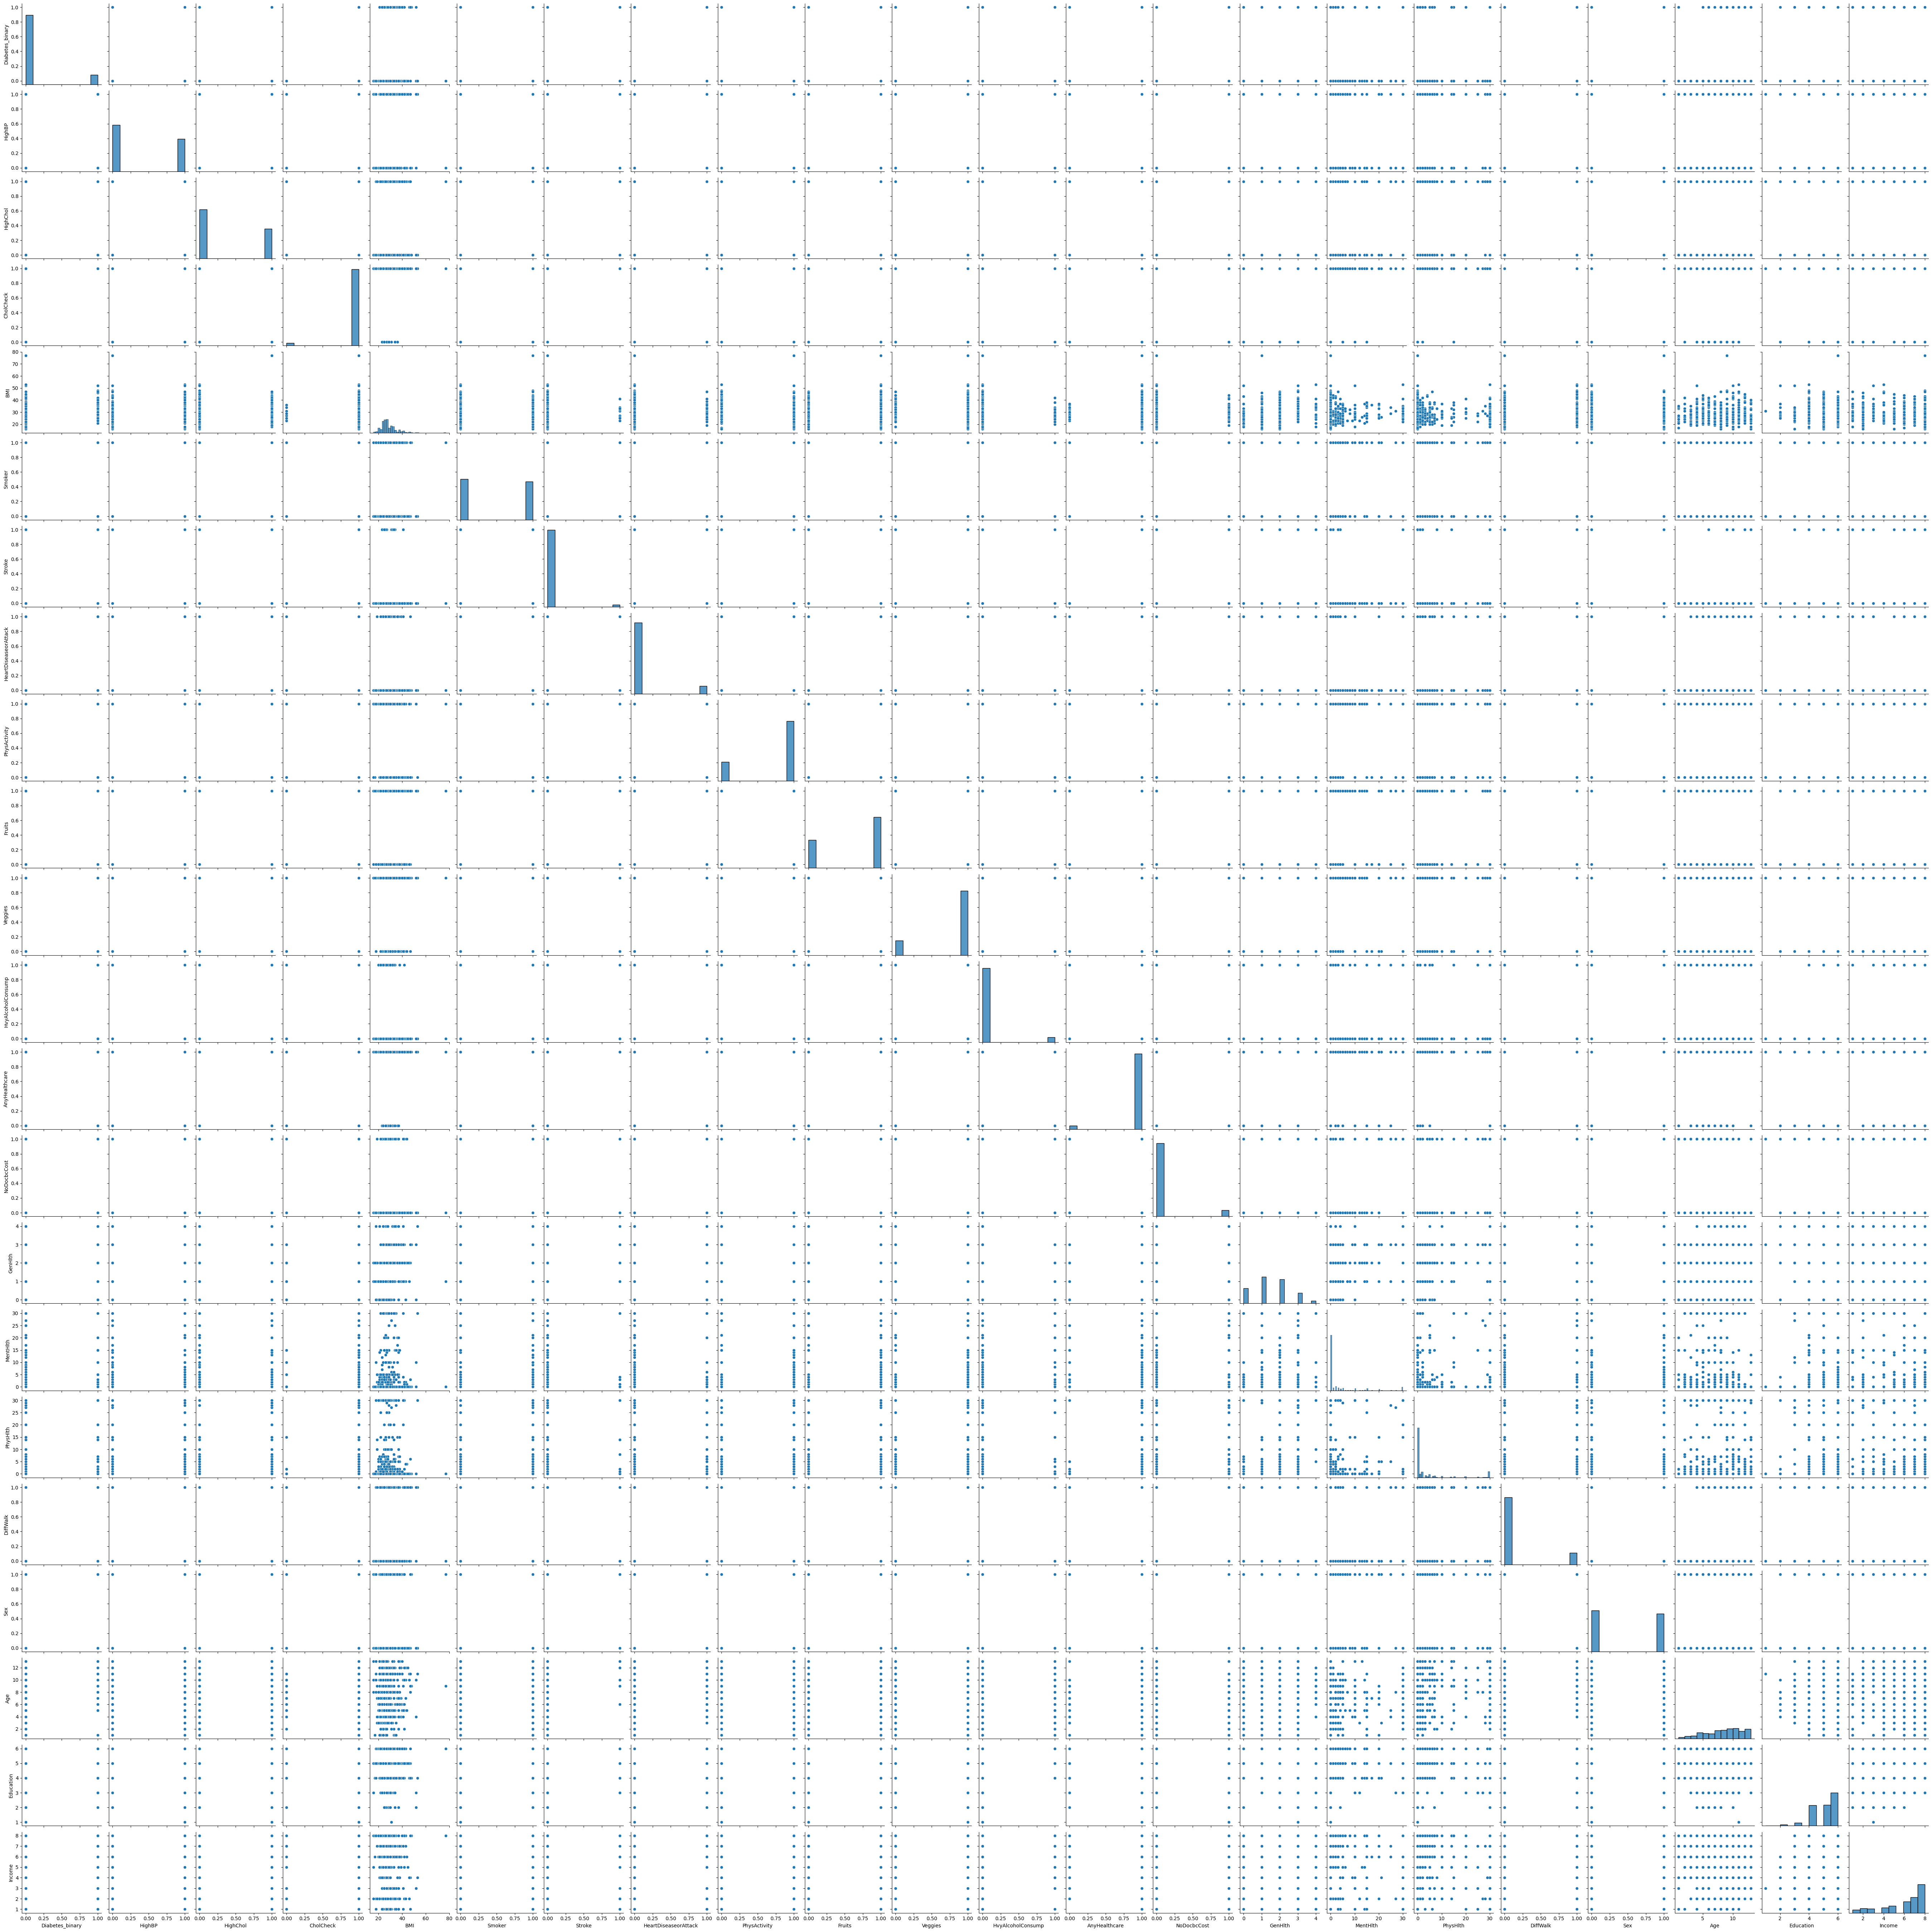

Correlation Heatmap EDA


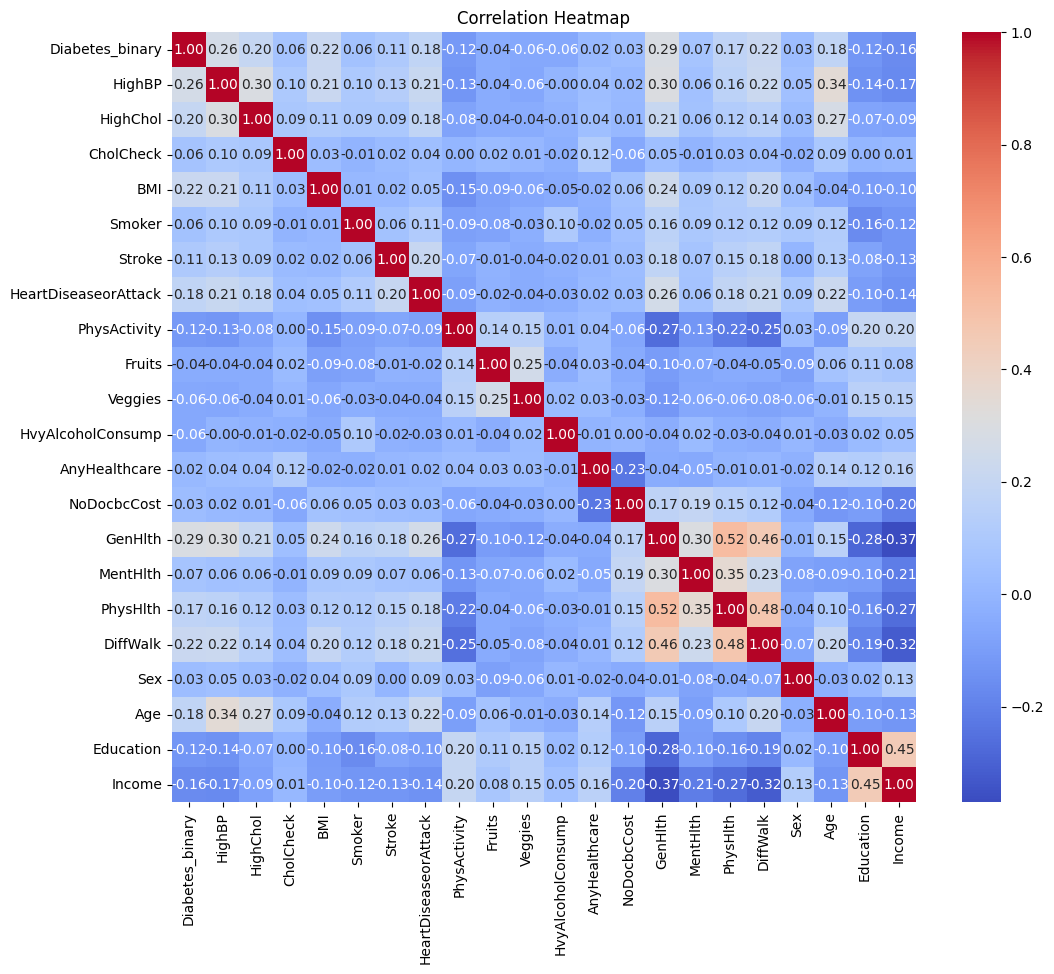

In [ ]:
# Step 6: Exploratory Data Analysis (EDA)
print("Step 6: Exploratory Data Analysis (EDA)")

import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot
print("Performing Pairplot EDA")
sns.pairplot(df.sample(n=500, random_state=42))  # Sampling to improve performance
plt.show()

# Correlation Heatmap
print("Correlation Heatmap EDA")
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Step 7: Calculate Correlation with Target Variable
print("Step 7: Calculating Correlation with Target Variable")

# Compute correlation matrix
correlation_matrix = df.corr()

# Calculate correlation with the target variable
target_column = 'Diabetes_binary'  # Replace with your target column name
correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)

# Display the correlations
print("Correlation with Target Variable:")
print(correlation_with_target)


Step 7: Calculating Correlation with Target Variable
Correlation with Target Variable:
Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64


Step 8: Visualizing Correlation with Target Variable


<ipython-input-8-6665a5600e11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')


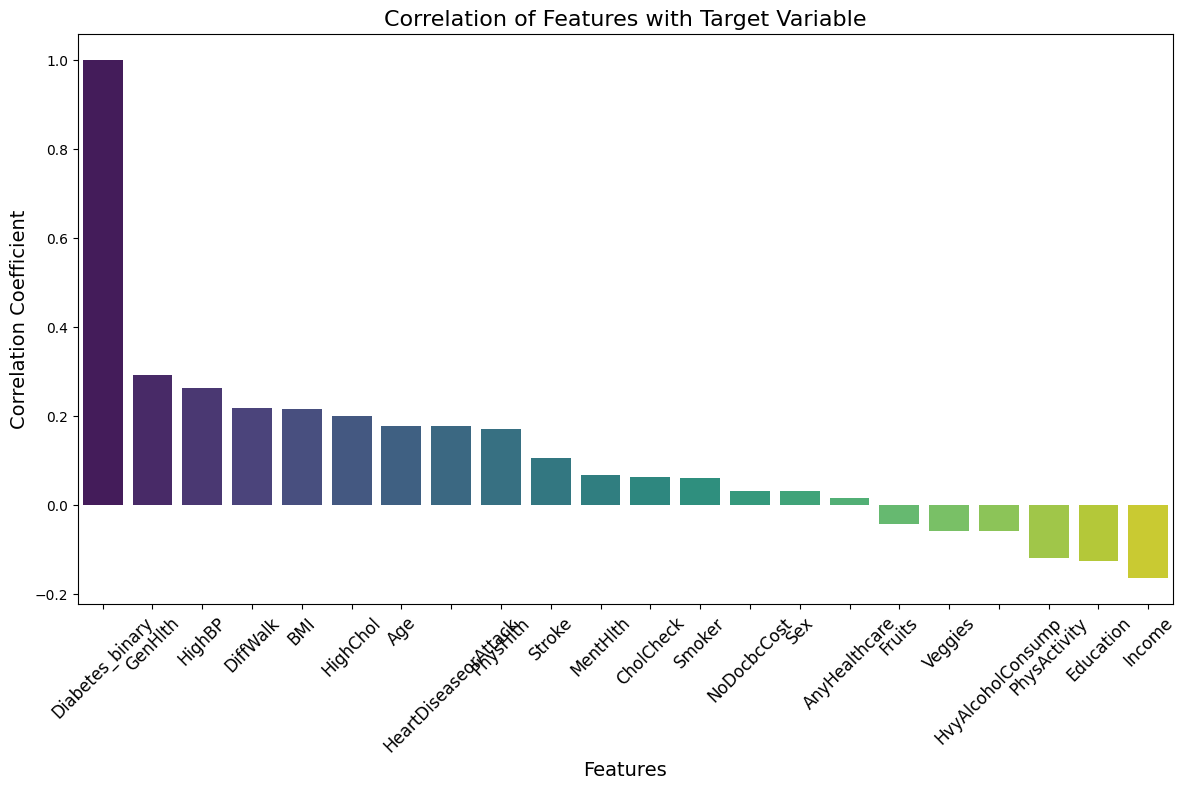

In [ ]:
# Step 8: Visualize Correlation with Target Variable
print("Step 8: Visualizing Correlation with Target Variable")

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation values
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')

# Adding titles and labels
plt.title('Correlation of Features with Target Variable', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()  # Adjust layout to fit the rotated labels
plt.show()


Step 9: Creating Density Plot for Individual Numerical Features
Density Plot for BMI


<ipython-input-9-4f42b73648ba>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, color='blue')


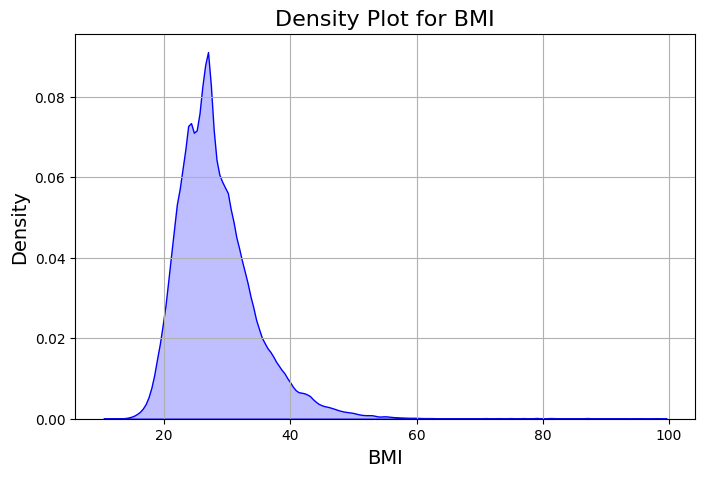

Density Plot for MentHlth


<ipython-input-9-4f42b73648ba>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, color='blue')


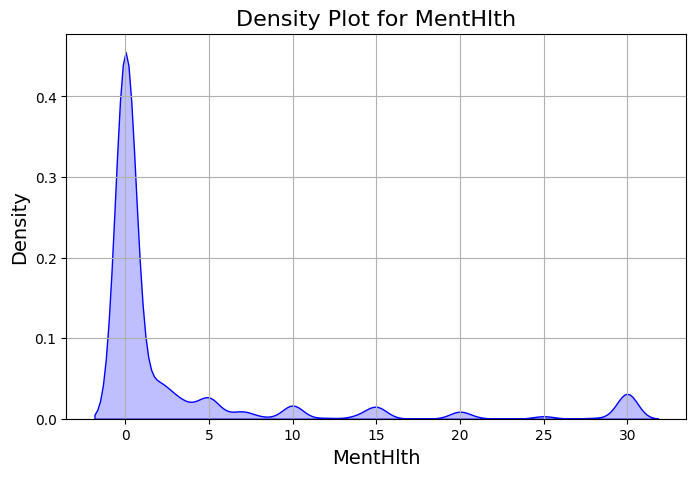

Density Plot for PhysHlth


<ipython-input-9-4f42b73648ba>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, color='blue')


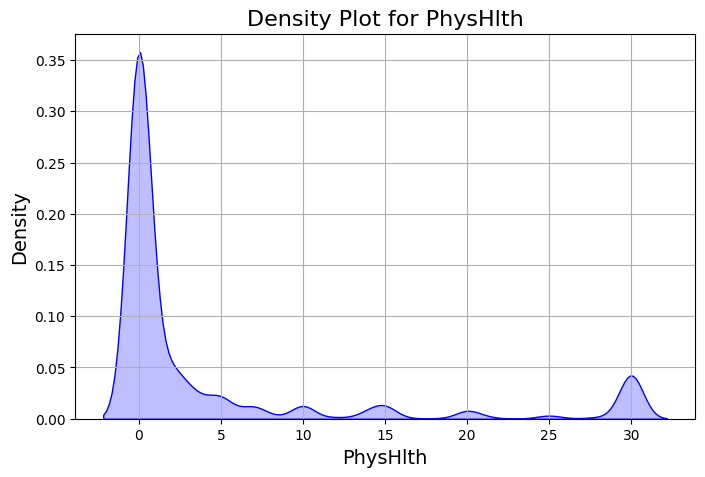

Density Plot for Age


<ipython-input-9-4f42b73648ba>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, color='blue')


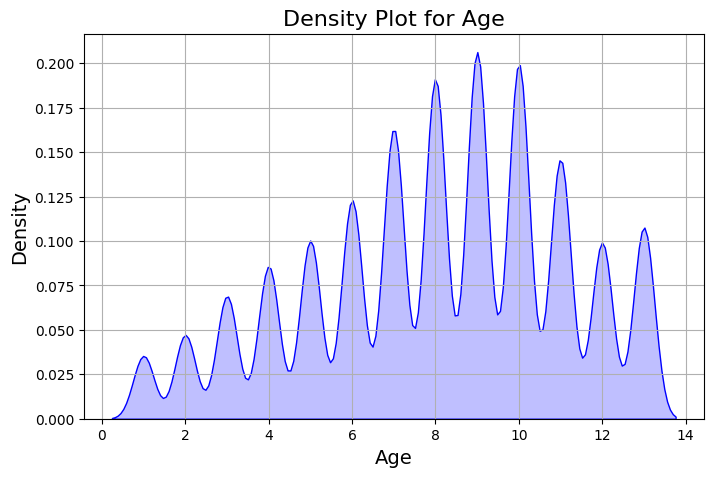

Density Plot for Income


<ipython-input-9-4f42b73648ba>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, color='blue')


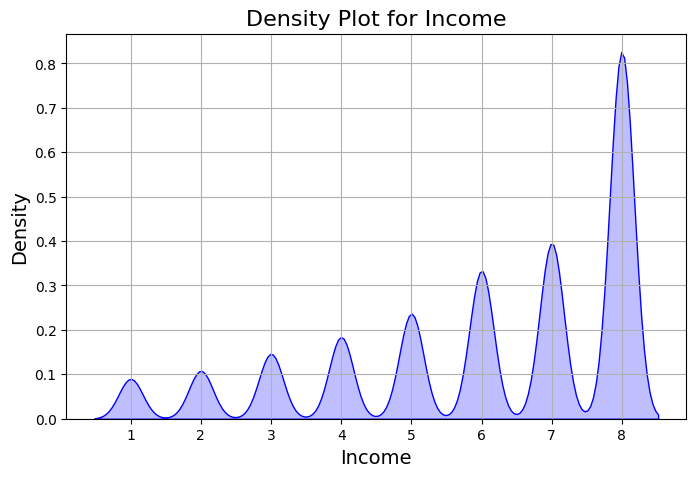

Density Plot for Education


<ipython-input-9-4f42b73648ba>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, color='blue')


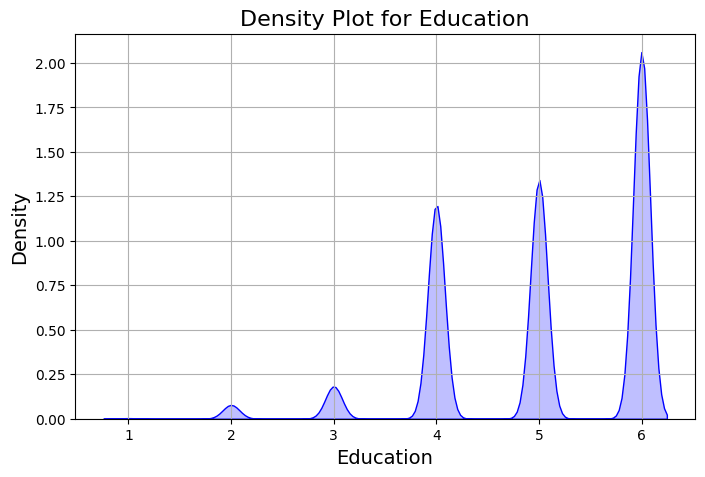

In [ ]:
# Step 9: Density Plot for Individual Numerical Features
print("Step 9: Creating Density Plot for Individual Numerical Features")

import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features for density plots
# Update this list based on your dataset's numerical columns
numerical_features = ['BMI', 'MentHlth', 'PhysHlth', 'Age','Income','Education']

for feature in numerical_features:
    print(f"Density Plot for {feature}")
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df[feature], shade=True, color='blue')
    plt.title(f'Density Plot for {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()


Step 10: Checking for Class Imbalance
Class Distribution in the Target Variable:


<ipython-input-10-525e786fa4ec>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diabetes_binary', data=df, palette='pastel')


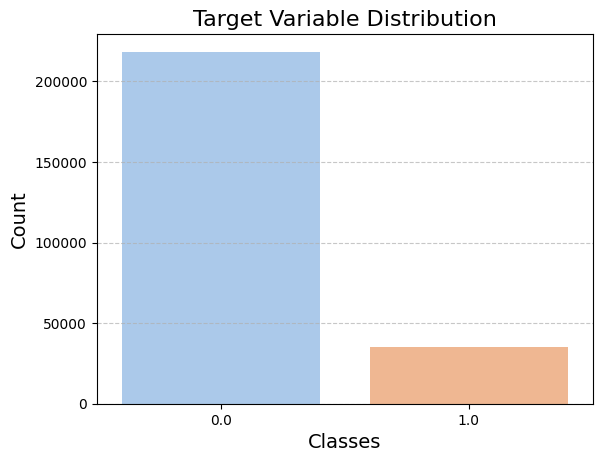

Class Imbalance: 
Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64


In [ ]:
# Step 10: Check for Class Imbalance
print("Step 10: Checking for Class Imbalance")

import seaborn as sns
import matplotlib.pyplot as plt

# Class Distribution in the Target Variable
print("Class Distribution in the Target Variable:")
sns.countplot(x='Diabetes_binary', data=df, palette='pastel')
plt.title('Target Variable Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display class counts
class_counts = df['Diabetes_binary'].value_counts()
print(f"Class Imbalance: \n{class_counts}")


In [ ]:
# Step 12: Calculating Correlation for Two-Variable Combinations
print("Step 12: Calculating Correlation for Two-Variable Combinations")

# Define pairs of variables for correlation calculation
pairs = [
    ('Age', 'BMI'),
    ('Age', 'MentHlth'),
    ('Age', 'PhysHlth'),
    ('Age', 'Income'),
    ('Age', 'Education'),
    ('BMI', 'MentHlth'),
    ('BMI', 'PhysHlth'),
    ('BMI', 'Income'),
    ('BMI', 'Education'),
    ('MentHlth', 'PhysHlth'),
    ('MentHlth', 'Income'),
    ('MentHlth', 'Education'),
    ('PhysHlth', 'Income'),
    ('PhysHlth', 'Education'),
    ('Income', 'Education')
]

# Calculate correlations and store results
correlation_results = []
for var1, var2 in pairs:
    correlation_value = df[var1].corr(df[var2])
    correlation_results.append((f"{var1} * {var2}", correlation_value))

# Create a DataFrame to display sorted correlation values
correlation_df = pd.DataFrame(correlation_results, columns=['Variable Pair', 'Correlation Value'])
correlation_df_sorted = correlation_df.sort_values(by='Correlation Value', ascending=False)

# Display the sorted correlation values
print("Correlation Values for Two-Variable Combinations (Highest to Lowest):")
print(correlation_df_sorted)


Step 12: Calculating Correlation for Two-Variable Combinations
Correlation Values for Two-Variable Combinations (Highest to Lowest):
           Variable Pair  Correlation Value
14    Income * Education           0.449106
9    MentHlth * PhysHlth           0.353619
6         BMI * PhysHlth           0.121141
2         Age * PhysHlth           0.099130
5         BMI * MentHlth           0.085310
0              Age * BMI          -0.036618
1         Age * MentHlth          -0.092068
7           BMI * Income          -0.100069
11  MentHlth * Education          -0.101830
4        Age * Education          -0.101901
8        BMI * Education          -0.103932
3           Age * Income          -0.127775
13  PhysHlth * Education          -0.155093
10     MentHlth * Income          -0.209806
12     PhysHlth * Income          -0.266799


Step 13: Creating Scatter Plots for Each Pair
Creating scatter plot for Age and BMI


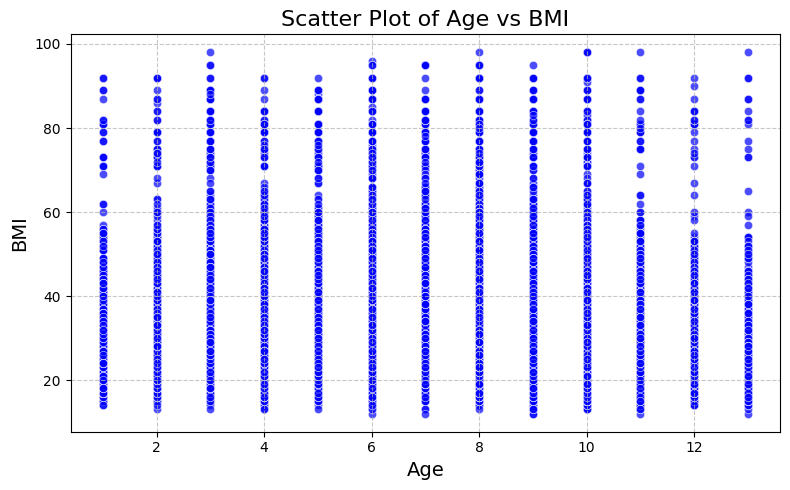

Creating scatter plot for Age and MentHlth


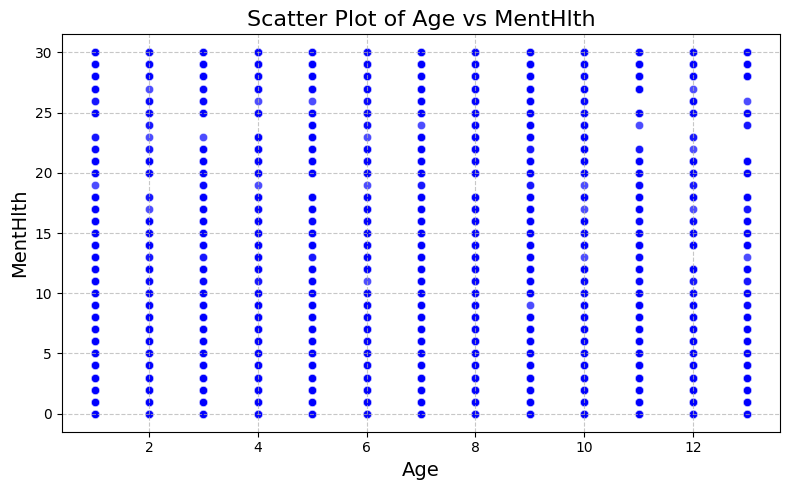

Creating scatter plot for Age and PhysHlth


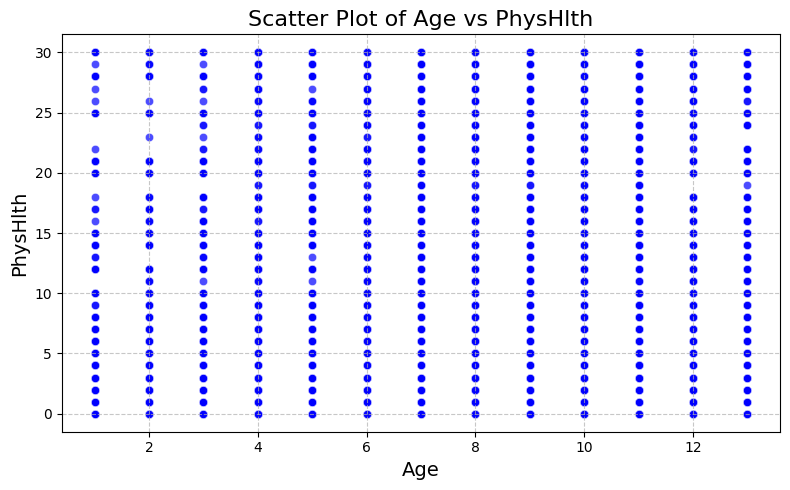

Creating scatter plot for Age and Income


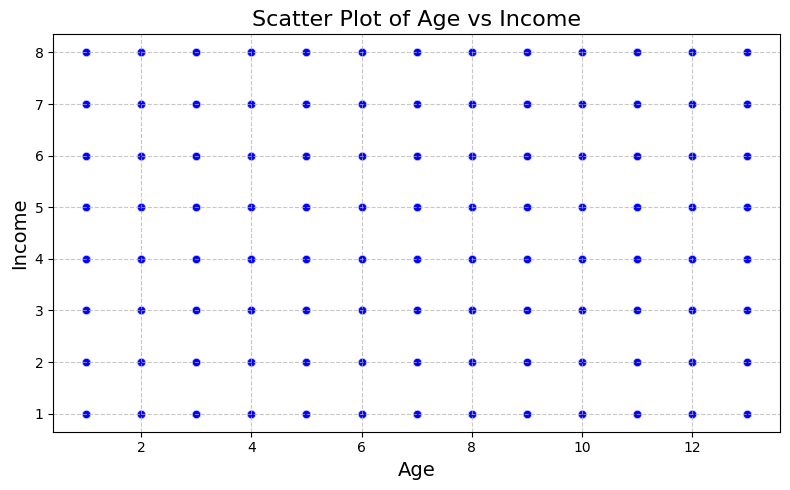

Creating scatter plot for Age and Education


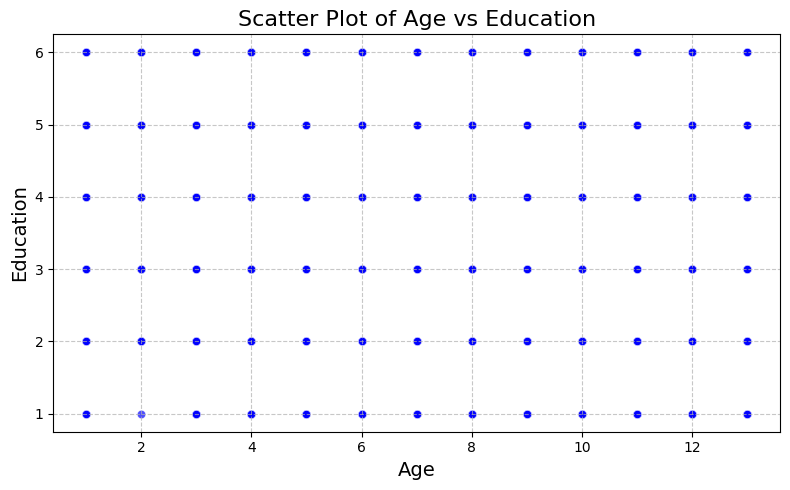

Creating scatter plot for BMI and MentHlth


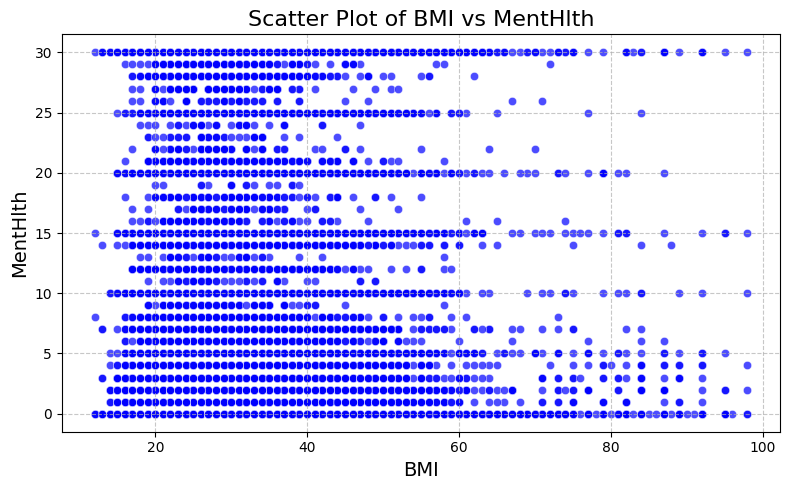

Creating scatter plot for BMI and PhysHlth


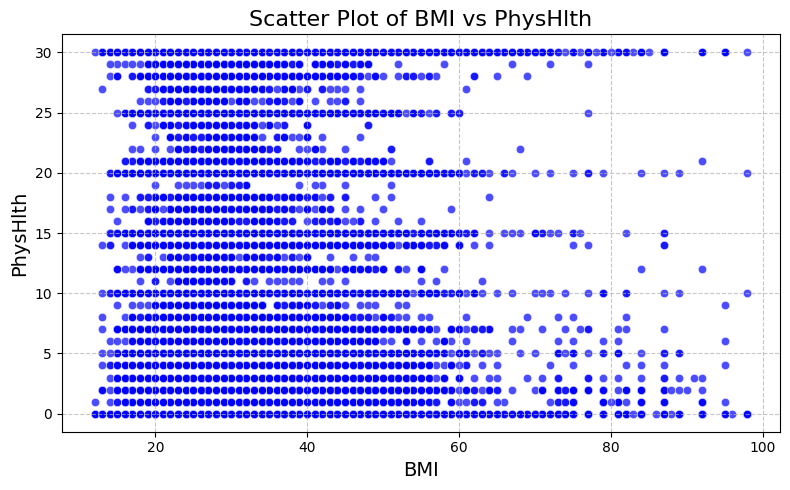

Creating scatter plot for BMI and Income


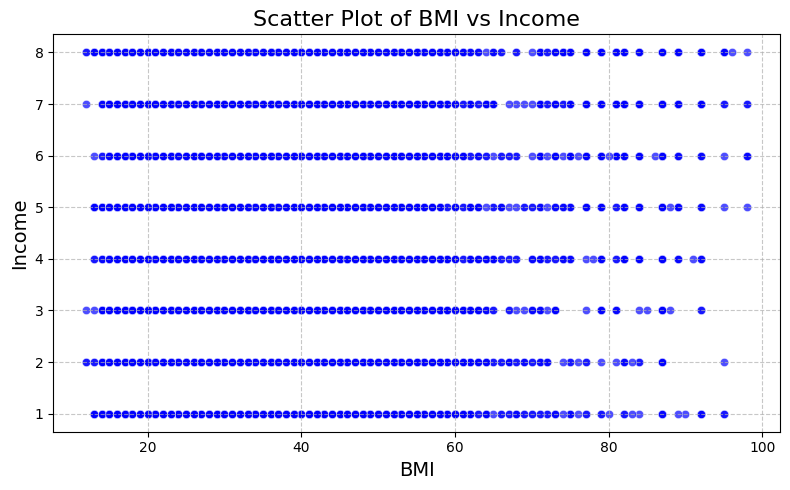

Creating scatter plot for BMI and Education


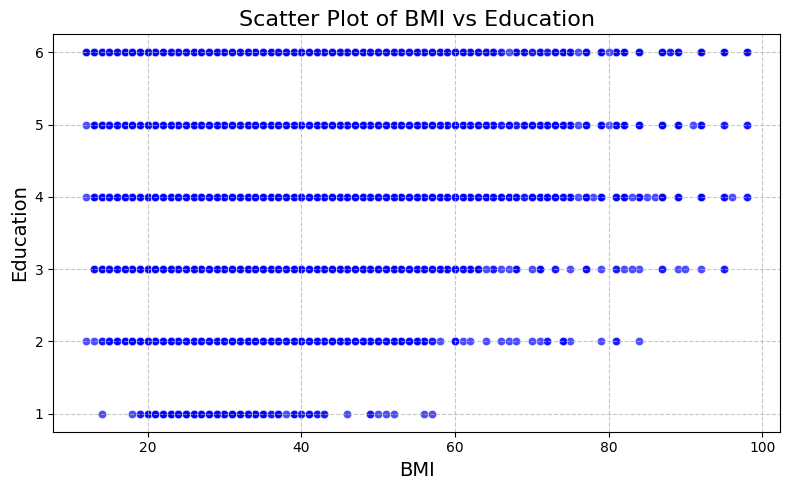

Creating scatter plot for MentHlth and PhysHlth


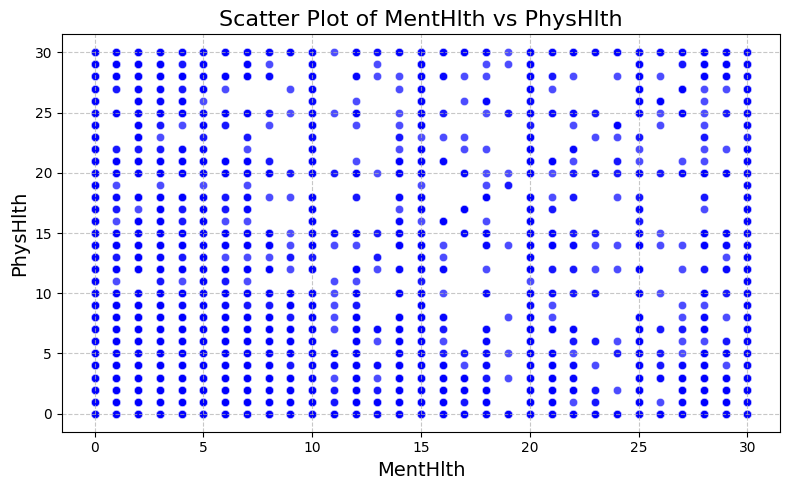

Creating scatter plot for MentHlth and Income


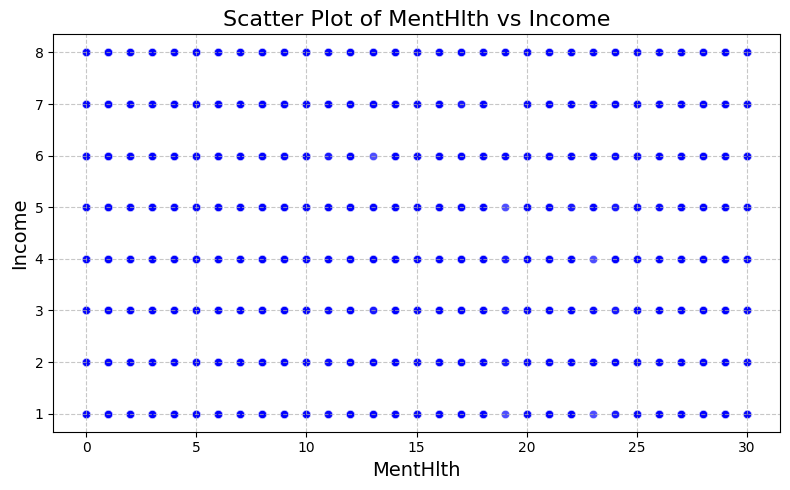

Creating scatter plot for MentHlth and Education


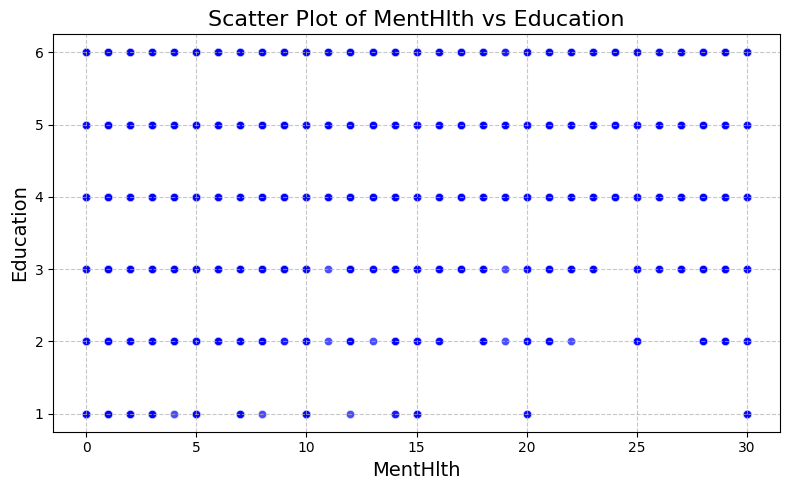

Creating scatter plot for PhysHlth and Income


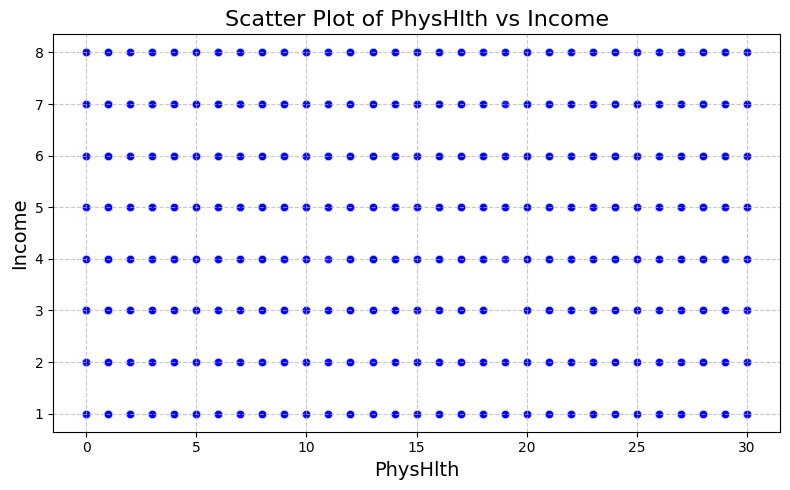

Creating scatter plot for PhysHlth and Education


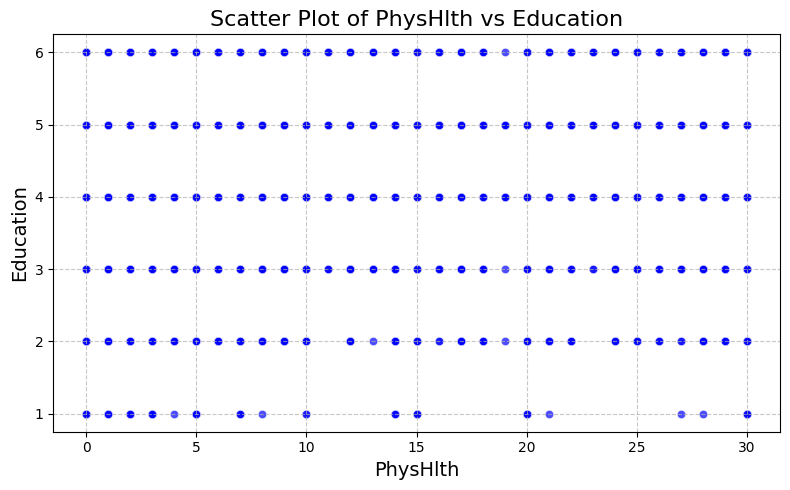

Creating scatter plot for Income and Education


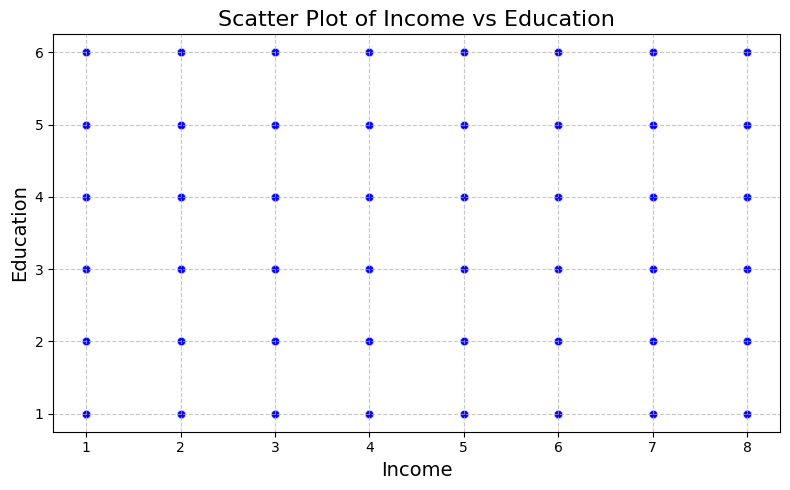

In [ ]:
# Step 13: Creating Scatter Plots for Each Pair
print("Step 13: Creating Scatter Plots for Each Pair")

# Generate scatter plots for the selected variable pairs
for var1, var2 in pairs:
    print(f"Creating scatter plot for {var1} and {var2}")
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=var1, y=var2, alpha=0.7, color='blue')
    plt.title(f'Scatter Plot of {var1} vs {var2}', fontsize=16)
    plt.xlabel(var1, fontsize=14)
    plt.ylabel(var2, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


In [ ]:
from scipy.stats import chi2_contingency

# Step: Performing Chi-Squared Test for Categorical Variables
print("Step: Performing Chi-Squared Test for Categorical Variables")

# Comprehensive list of categorical variable pairs
chi_squared_pairs = [
    ('Sex', 'HighBP'), ('Sex', 'HighChol'), ('Sex', 'CholCheck'), ('Sex', 'Smoker'), ('Sex', 'Stroke'),
    ('Sex', 'HeartDiseaseorAttack'), ('Sex', 'PhysActivity'), ('Sex', 'Fruits'), ('Sex', 'Veggies'),
    ('Sex', 'HvyAlcoholConsump'), ('Sex', 'AnyHealthcare'), ('Sex', 'NoDocbcCost'), ('Sex', 'GenHlth'),
    ('Sex', 'DiffWalk'),
    ('HighBP', 'HighChol'), ('HighBP', 'CholCheck'), ('HighBP', 'Smoker'), ('HighBP', 'Stroke'),
    ('HighBP', 'HeartDiseaseorAttack'), ('HighBP', 'PhysActivity'), ('HighBP', 'Fruits'), ('HighBP', 'Veggies'),
    ('HighBP', 'HvyAlcoholConsump'), ('HighBP', 'AnyHealthcare'), ('HighBP', 'NoDocbcCost'), ('HighBP', 'GenHlth'),
    ('HighBP', 'DiffWalk'),
    ('HighChol', 'CholCheck'), ('HighChol', 'Smoker'), ('HighChol', 'Stroke'), ('HighChol', 'HeartDiseaseorAttack'),
    ('CholCheck', 'Smoker'), ('CholCheck', 'Stroke'), ('CholCheck', 'HeartDiseaseorAttack'),
    ('Smoker', 'Stroke'), ('Smoker', 'HeartDiseaseorAttack'), ('Stroke', 'HeartDiseaseorAttack'),
    ('PhysActivity', 'Fruits'), ('PhysActivity', 'Veggies'), ('PhysActivity', 'HvyAlcoholConsump'),
    ('PhysActivity', 'AnyHealthcare'), ('PhysActivity', 'NoDocbcCost'), ('PhysActivity', 'GenHlth'),
    ('PhysActivity', 'DiffWalk'), ('Fruits', 'Veggies'), ('Fruits', 'HvyAlcoholConsump'),
    ('Fruits', 'AnyHealthcare'), ('Fruits', 'NoDocbcCost'), ('Fruits', 'GenHlth'), ('Fruits', 'DiffWalk'),
    ('Veggies', 'HvyAlcoholConsump'), ('Veggies', 'AnyHealthcare'), ('Veggies', 'NoDocbcCost'),
    ('Veggies', 'GenHlth'), ('Veggies', 'DiffWalk'), ('HvyAlcoholConsump', 'AnyHealthcare'),
    ('HvyAlcoholConsump', 'NoDocbcCost'), ('HvyAlcoholConsump', 'GenHlth'), ('HvyAlcoholConsump', 'DiffWalk'),
    ('AnyHealthcare', 'NoDocbcCost'), ('AnyHealthcare', 'GenHlth'), ('AnyHealthcare', 'DiffWalk'),
    ('NoDocbcCost', 'GenHlth'), ('NoDocbcCost', 'DiffWalk'), ('GenHlth', 'DiffWalk')
]

# Conducting chi-squared test for each pair
print("Chi-Squared Test Results:")
for var1, var2 in chi_squared_pairs:
    contingency_table = pd.crosstab(df[var1], df[var2])  # Create contingency table
    chi2, p, dof, expected = chi2_contingency(contingency_table)  # Chi-squared test
    print(f"\nChi-Squared Test for {var1} and {var2}:")
    print(f"Chi2 Statistic: {chi2:.4f}, P-value: {p:.4f}, Degrees of Freedom: {dof}")
    if p < 0.05:
        print("   -> Significant relationship (p < 0.05).")
    else:
        print("   -> No significant relationship (p >= 0.05).")


Step: Performing Chi-Squared Test for Categorical Variables
Chi-Squared Test Results:

Chi-Squared Test for Sex and HighBP:
Chi2 Statistic: 691.2093, P-value: 0.0000, Degrees of Freedom: 1
   -> Significant relationship (p < 0.05).

Chi-Squared Test for Sex and HighChol:
Chi2 Statistic: 246.8995, P-value: 0.0000, Degrees of Freedom: 1
   -> Significant relationship (p < 0.05).

Chi-Squared Test for Sex and CholCheck:
Chi2 Statistic: 123.8336, P-value: 0.0000, Degrees of Freedom: 1
   -> Significant relationship (p < 0.05).

Chi-Squared Test for Sex and Smoker:
Chi2 Statistic: 2225.0630, P-value: 0.0000, Degrees of Freedom: 1
   -> Significant relationship (p < 0.05).

Chi-Squared Test for Sex and Stroke:
Chi2 Statistic: 2.2199, P-value: 0.1362, Degrees of Freedom: 1
   -> No significant relationship (p >= 0.05).

Chi-Squared Test for Sex and HeartDiseaseorAttack:
Chi2 Statistic: 1879.7932, P-value: 0.0000, Degrees of Freedom: 1
   -> Significant relationship (p < 0.05).

Chi-Squared Te

In [ ]:
print("Feature Engineering - Creating New Features")

# Creating interaction features based on the dataset's columns
df['Sex_HighBP'] = df['Sex'] * df['HighBP']
df['Sex_HighChol'] = df['Sex'] * df['HighChol']
df['Sex_CholCheck'] = df['Sex'] * df['CholCheck']
df['Sex_Smoker'] = df['Sex'] * df['Smoker']
df['Sex_HeartDiseaseorAttack'] = df['Sex'] * df['HeartDiseaseorAttack']
df['Sex_PhysActivity'] = df['Sex'] * df['PhysActivity']
df['Sex_Fruits'] = df['Sex'] * df['Fruits']
df['Sex_Veggies'] = df['Sex'] * df['Veggies']
df['Sex_HvyAlcoholConsump'] = df['Sex'] * df['HvyAlcoholConsump']
df['Sex_AnyHealthcare'] = df['Sex'] * df['AnyHealthcare']
df['Sex_NoDocbcCost'] = df['Sex'] * df['NoDocbcCost']
df['Sex_GenHlth'] = df['Sex'] * df['GenHlth']
df['Sex_DiffWalk'] = df['Sex'] * df['DiffWalk']

df['HighBP_HighChol'] = df['HighBP'] * df['HighChol']
df['HighBP_CholCheck'] = df['HighBP'] * df['CholCheck']
df['HighBP_Smoker'] = df['HighBP'] * df['Smoker']
df['HighBP_Stroke'] = df['HighBP'] * df['Stroke']
df['HighBP_HeartDiseaseorAttack'] = df['HighBP'] * df['HeartDiseaseorAttack']
df['HighBP_PhysActivity'] = df['HighBP'] * df['PhysActivity']
df['HighBP_Fruits'] = df['HighBP'] * df['Fruits']
df['HighBP_Veggies'] = df['HighBP'] * df['Veggies']
df['HighBP_HvyAlcoholConsump'] = df['HighBP'] * df['HvyAlcoholConsump']
df['HighBP_AnyHealthcare'] = df['HighBP'] * df['AnyHealthcare']
df['HighBP_NoDocbcCost'] = df['HighBP'] * df['NoDocbcCost']
df['HighBP_GenHlth'] = df['HighBP'] * df['GenHlth']
df['HighBP_DiffWalk'] = df['HighBP'] * df['DiffWalk']

df['HighChol_CholCheck'] = df['HighChol'] * df['CholCheck']
df['HighChol_Smoker'] = df['HighChol'] * df['Smoker']
df['HighChol_Stroke'] = df['HighChol'] * df['Stroke']
df['HighChol_HeartDiseaseorAttack'] = df['HighChol'] * df['HeartDiseaseorAttack']

df['CholCheck_Smoker'] = df['CholCheck'] * df['Smoker']
df['CholCheck_Stroke'] = df['CholCheck'] * df['Stroke']
df['CholCheck_HeartDiseaseorAttack'] = df['CholCheck'] * df['HeartDiseaseorAttack']

df['Smoker_Stroke'] = df['Smoker'] * df['Stroke']
df['Smoker_HeartDiseaseorAttack'] = df['Smoker'] * df['HeartDiseaseorAttack']
df['Stroke_HeartDiseaseorAttack'] = df['Stroke'] * df['HeartDiseaseorAttack']

df['PhysActivity_Fruits'] = df['PhysActivity'] * df['Fruits']
df['PhysActivity_Veggies'] = df['PhysActivity'] * df['Veggies']
df['PhysActivity_HvyAlcoholConsump'] = df['PhysActivity'] * df['HvyAlcoholConsump']
df['PhysActivity_AnyHealthcare'] = df['PhysActivity'] * df['AnyHealthcare']
df['PhysActivity_NoDocbcCost'] = df['PhysActivity'] * df['NoDocbcCost']
df['PhysActivity_GenHlth'] = df['PhysActivity'] * df['GenHlth']
df['PhysActivity_DiffWalk'] = df['PhysActivity'] * df['DiffWalk']

df['Fruits_Veggies'] = df['Fruits'] * df['Veggies']
df['Fruits_HvyAlcoholConsump'] = df['Fruits'] * df['HvyAlcoholConsump']
df['Fruits_AnyHealthcare'] = df['Fruits'] * df['AnyHealthcare']
df['Fruits_NoDocbcCost'] = df['Fruits'] * df['NoDocbcCost']
df['Fruits_GenHlth'] = df['Fruits'] * df['GenHlth']
df['Fruits_DiffWalk'] = df['Fruits'] * df['DiffWalk']

df['Veggies_HvyAlcoholConsump'] = df['Veggies'] * df['HvyAlcoholConsump']
df['Veggies_AnyHealthcare'] = df['Veggies'] * df['AnyHealthcare']
df['Veggies_NoDocbcCost'] = df['Veggies'] * df['NoDocbcCost']
df['Veggies_GenHlth'] = df['Veggies'] * df['GenHlth']
df['Veggies_DiffWalk'] = df['Veggies'] * df['DiffWalk']

df['HvyAlcoholConsump_AnyHealthcare'] = df['HvyAlcoholConsump'] * df['AnyHealthcare']
df['HvyAlcoholConsump_NoDocbcCost'] = df['HvyAlcoholConsump'] * df['NoDocbcCost']
df['HvyAlcoholConsump_GenHlth'] = df['HvyAlcoholConsump'] * df['GenHlth']
df['HvyAlcoholConsump_DiffWalk'] = df['HvyAlcoholConsump'] * df['DiffWalk']

df['AnyHealthcare_NoDocbcCost'] = df['AnyHealthcare'] * df['NoDocbcCost']
df['AnyHealthcare_GenHlth'] = df['AnyHealthcare'] * df['GenHlth']
df['AnyHealthcare_DiffWalk'] = df['AnyHealthcare'] * df['DiffWalk']

df['NoDocbcCost_GenHlth'] = df['NoDocbcCost'] * df['GenHlth']
df['NoDocbcCost_DiffWalk'] = df['NoDocbcCost'] * df['DiffWalk']

df['GenHlth_DiffWalk'] = df['GenHlth'] * df['DiffWalk']

# Additional interaction features
df['Income_Education'] = df['Income'] * df['Education']
df['MentHlth_PhysHlth'] = df['MentHlth'] * df['PhysHlth']
df['BMI_PhysHlth'] = df['BMI'] * df['PhysHlth']

# Display the new features
print("New Features Created:")
print(df.head())


Feature Engineering - Creating New Features
New Features Created:
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0       1         1          1  40.0       1       0   
1              0.0       0         0          0  25.0       1       0   
2              0.0       1         1          1  28.0       0       0   
3              0.0       1         0          1  27.0       0       0   
4              0.0       1         1          1  24.0       0       0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  \
0                     0             0       0  ...   
1                     0             1       0  ...   
2                     0             0       1  ...   
3                     0             1       1  ...   
4                     0             1       1  ...   

   HvyAlcoholConsump_DiffWalk  AnyHealthcare_NoDocbcCost  \
0                           0                          0   
1                           0                     

In [ ]:
# Step 17: Feature Scaling
print("Step 17: Feature Scaling")

# Select the new features for scaling
new_features = ['BMI', 'MentHlth', 'PhysHlth', 'Age','Income','Education', 'Income_Education', 'MentHlth_PhysHlth', 'BMI_PhysHlth']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the new features
df[new_features] = scaler.fit_transform(df[new_features])

print("Feature Scaling Applied:")
print(df[new_features].head())  # Display scaled new features


Step 17: Feature Scaling
Feature Scaling Applied:
        BMI  MentHlth  PhysHlth       Age    Income  Education  \
0  1.757936  1.998592  1.233999  0.316900 -1.474487  -1.065595   
1 -0.511806 -0.429630 -0.486592 -0.337933 -2.440138   0.963272   
2 -0.057858  3.617407  2.954590  0.316900  0.939638  -1.065595   
3 -0.209174 -0.429630 -0.486592  0.971733 -0.026012  -2.080028   
4 -0.663122 -0.024926 -0.486592  0.971733 -0.991662  -0.051162   

   Income_Education  MentHlth_PhysHlth  BMI_PhysHlth  
0         -1.437062           1.604094      1.717223  
1         -1.879425          -0.249656     -0.462823  
2          0.037481           5.929508      2.589241  
3         -0.994699          -0.249656     -0.462823  
4         -0.847245          -0.249656     -0.462823  


In [ ]:
# Step 19: Applying SMOTE for Imbalanced Data
print("Step 19: Applying SMOTE for Imbalanced Data")

# Define independent (X) and dependent (y) variables for SMOTE
X = df.drop(columns=['Diabetes_binary'])  # Drop the target column to define the features
y = df['Diabetes_binary']  # The target variable

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the new class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())


Step 19: Applying SMOTE for Imbalanced Data
Class distribution after SMOTE:
Diabetes_binary
0.0    218334
1.0    218334
Name: count, dtype: int64


In [ ]:
# Step 20: Performing Train-Test Split (70-30%)
print("Step 20: Performing Train-Test Split (70-30%)")

# Split the resampled data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")


Step 20: Performing Train-Test Split (70-30%)
Training Set Shape: (305667, 88)
Testing Set Shape: (131001, 88)


In [ ]:
# Step 21: Applying PCA for Dimensionality Reduction
print("Step 21: Applying PCA for Dimensionality Reduction")

# Initialize PCA and reduce dimensionality to retain 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the training set and transform both training and testing sets
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")


Step 21: Applying PCA for Dimensionality Reduction
Original number of features: 88
Reduced number of features after PCA: 23


In [ ]:
# Import necessary libraries
import time
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Define models and hyperparameters
models = {
    'RandomForest': (
        RandomForestClassifier(),
        {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 0.2]}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    'LightGBM': (
        LGBMClassifier(),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    'CatBoost': (
        CatBoostClassifier(silent=True),
        {'iterations': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    'SVM': (
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    ),
    'MLP': (
        MLPClassifier(max_iter=500),
        {'hidden_layer_sizes': [(10,), (20,), (30,)], 'activation': ['tanh', 'relu']}
    )
}

# Variables to track the best models, metrics, and run times
best_models = {}
run_times = {}
metrics = {}

# Step 22: Model Selection, Hyperparameter Tuning, and Tracking Run Time
print("Step 22: Model Selection, Hyperparameter Tuning, and Tracking Run Time")

for model_name, (model, params) in models.items():
    try:
        print(f"Training {model_name}...")
        start_time = time.time()

        # Randomized Search CV for hyperparameter tuning
        search = RandomizedSearchCV(
            model, params, n_iter=10, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            verbose=0, random_state=42, scoring='roc_auc'
        )
        search.fit(X_train_pca, y_train)

        elapsed_time = time.time() - start_time
        best_model = search.best_estimator_
        best_models[model_name] = best_model
        run_times[model_name] = elapsed_time

        y_pred = best_model.predict(X_test_pca)
        y_pred_prob = best_model.predict_proba(X_test_pca)[:, 1] if hasattr(best_model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

        metrics[model_name] = {'accuracy': acc, 'roc_auc': auc}
        print(f"Best Parameters for {model_name}: {search.best_params_}")
        print(f"Run Time for {model_name}: {elapsed_time:.2f} seconds")
        print(f"Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}" if auc else f"Accuracy: {acc:.4f}")

    except Exception as e:
        print(f"An error occurred with {model_name}: {e}")

# Step 23: Creating Voting Classifier and Tracking Run Time
print("\nStep 23: Creating Voting Classifier and Tracking Run Time")
estimators = [(name, model) for name, model in best_models.items()]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

start_time = time.time()
voting_clf.fit(X_train_pca, y_train)
voting_elapsed_time = time.time() - start_time

voting_acc = accuracy_score(y_test, voting_clf.predict(X_test_pca))
voting_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_pca)[:, 1])
print(f"Voting Classifier Training Time: {voting_elapsed_time:.2f} seconds")
print(f"Voting Classifier Accuracy: {voting_acc:.4f}, ROC-AUC: {voting_auc:.4f}")

# Step 24: Voting Classifier Performance
print("\nVoting Classifier Results:")
y_pred_voting = voting_clf.predict(X_test_pca)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_voting).ravel()
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = tp / (tp + fn)
specificity_voting = tn / (tn + fp)
f1_voting = f1_score(y_test, y_pred_voting)
print(f"Accuracy: {voting_acc:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Sensitivity (Recall): {recall_voting:.4f}")
print(f"Specificity: {specificity_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")

disp_voting = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_voting), display_labels=[0, 1])
disp_voting.plot(cmap='Blues')
plt.title('Voting Classifier Confusion Matrix')
plt.show()

# Step 26: Model Evaluation Metrics for All Models
print("\nStep 26: Model Evaluation Metrics for All Models")

for model_name, model in best_models.items():
    y_pred = model.predict(X_test_pca)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

print("\nNote: Sensitivity (recall) and specificity are crucial for balanced predictions in heart disease diagnosis.")


Step 22: Model Selection, Hyperparameter Tuning, and Tracking Run Time
Training RandomForest...
Best Parameters for RandomForest: {'n_estimators': 200, 'max_depth': None}
Run Time for RandomForest: 8095.98 seconds
Accuracy: 0.8662, ROC-AUC: 0.9425
Training GradientBoosting...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for GradientBoosting: {'n_estimators': 100, 'learning_rate': 0.2}
Run Time for GradientBoosting: 5566.95 seconds
Accuracy: 0.7574, ROC-AUC: 0.8340
Training XGBoost...
An error occurred with XGBoost: 'super' object has no attribute '__sklearn_tags__'
Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tag

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101952, number of negative: 101826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500309 -> initscore=0.001237
[LightGBM] [Info] Start training from score 0.001237


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101952, number of negative: 101826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500309 -> initscore=0.001237
[LightGBM] [Info] Start training from score 0.001237


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101952, number of negative: 101826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500309 -> initscore=0.001237
[LightGBM] [Info] Start training from score 0.001237


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101951, number of negative: 101827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500304 -> initscore=0.001217
[LightGBM] [Info] Start training from score 0.001217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 101952, number of negative: 101826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 203778, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500309 -> initscore=0.001237
[LightGBM] [Info] Start training from score 0.001237


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 152927, number of negative: 152740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500306 -> initscore=0.001224
[LightGBM] [Info] Start training from score 0.001224


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Parameters for LightGBM: {'n_estimators': 100, 'learning_rate': 0.1}
Run Time for LightGBM: 71.17 seconds
Accuracy: 0.7654, ROC-AUC: 0.8418
Training CatBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for CatBoost: {'learning_rate': 0.1, 'iterations': 100}
Run Time for CatBoost: 111.08 seconds
Accuracy: 0.7576, ROC-AUC: 0.8339
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
# Import necessary libraries
import time
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train XGBoost with default parameters
print("Training XGBoost model with default parameters...")

# Record the start time
start_time = time.time()

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)

# Fit the model on the training data
xgb.fit(X_train_pca, y_train)

# Calculate training time
elapsed_time = time.time() - start_time

# Make predictions
y_pred = xgb.predict(X_test_pca)
y_pred_prob = xgb.predict_proba(X_test_pca)[:, 1]  # Assuming binary classification

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Print results
print(f"\nXGBoost Model Results:")
print(f"Training Time: {elapsed_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {auc:.4f}")

# Confusion Matrix and additional metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming X_train_pca and y_train are your training features and labels
# If you're using PCA-transformed data, ensure that the following variables are defined:
# X_train_pca, X_test_pca, y_train, y_test

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the model on the training data
xgb_model.fit(X_train_pca, y_train)

print("Step 27: Model Evaluation and ROC Curves")

# Plot ROC Curve for each model
plt.figure(figsize=(12, 8))

# Iterate over each model in best_models to evaluate and plot ROC curves
for model_name, model in best_models.items():
    # Get predicted probabilities for the positive class
    y_pred_prob = model.predict_proba(X_test_pca)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    auc_value = auc(fpr, tpr)

    # Calculate confusion matrix and specificity
    y_pred = model.predict(X_test_pca)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate

    # Print sensitivity and specificity
    print(f"\n{model_name} Model Metrics:")
    print(f"AUC: {auc_value:.2f}")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.2f}")
    print(f"Specificity (True Negative Rate): {specificity:.2f}")

    # Plot ROC curve for the model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.2f})')

# Evaluate and plot ROC for Voting Classifier
y_pred_prob_voting = voting_clf.predict_proba(X_test_pca)[:, 1]  # Get predicted probabilities for the positive class
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_pred_prob_voting)  # Compute ROC curve
auc_value_voting = auc(fpr_voting, tpr_voting)  # Compute AUC for the Voting Classifier

# Calculate confusion matrix and specificity for Voting Classifier
y_pred_voting = voting_clf.predict(X_test_pca)
tn_voting, fp_voting, fn_voting, tp_voting = confusion_matrix(y_test, y_pred_voting).ravel()
sensitivity_voting = tp_voting / (tp_voting + fn_voting)  # True Positive Rate
specificity_voting = tn_voting / (tn_voting + fp_voting)  # True Negative Rate

# Print sensitivity and specificity for Voting Classifier
print("\nVoting Classifier Metrics:")
print(f"AUC: {auc_value_voting:.2f}")
print(f"Sensitivity (True Positive Rate): {sensitivity_voting:.2f}")
print(f"Specificity (True Negative Rate): {specificity_voting:.2f}")

# Plot ROC curve for Voting Classifier
plt.plot(fpr_voting, tpr_voting, label=f'Voting Classifier (AUC = {auc_value_voting:.2f})', linestyle='--')

# Add ROC Curve for XGBoost model
y_pred_prob_xgb = xgb_model.predict_proba(X_test_pca)[:, 1]  # Get predicted probabilities for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)  # Compute ROC curve for XGBoost
auc_value_xgb = auc(fpr_xgb, tpr_xgb)  # Compute AUC for XGBoost

# Calculate confusion matrix and specificity for XGBoost
y_pred_xgb = xgb_model.predict(X_test_pca)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()
sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)  # True Positive Rate
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)  # True Negative Rate

# Print sensitivity and specificity for XGBoost
print("\nXGBoost Model Metrics:")
print(f"AUC: {auc_value_xgb:.2f}")
print(f"Sensitivity (True Positive Rate): {sensitivity_xgb:.2f}")
print(f"Specificity (True Negative Rate): {specificity_xgb:.2f}")

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_value_xgb:.2f})', linestyle='-.')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guessing line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()
